This script is basically a reconstruction of 062. 

In [109]:
import os
os.listdir()

['243_22562_220-pycharm-support-libs',
 'Phase1.npz',
 '._.DS_Store',
 'data',
 'phase3_new.npz',
 'Phase2.npz',
 'pds',
 '.DS_Store',
 'DSS_analyzer_Mariner',
 'Phase3_prev.npz',
 'Phase3.npz']

In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from pds.DSS_analyzer_Mariner import Data1D_GAUGE, Data1D_PumpingCurve
from scipy.interpolate import interp1d

In [112]:
# Specify the datapath
datapath = "./data"

# Pressure gauge data (Only S well)
gauge_data_foler = datapath + "/gauge_data_swell"

In [113]:
# Load the pressure gauge data. Most close to the first stage is gauge 6. For the stage 8 I need to use gauge 7.
gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_foler + f"/gauge6_data_swell.npz")
gauge_dataframe_next = Data1D_GAUGE.Data1D_GAUGE(gauge_data_foler + f"/gauge7_data_swell.npz")

# Load the pumping curve data (stage7; stage8)
pumping_curve_filepath = datapath + f"/pumping_curve/pumping_curve_stage7.npz"
pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

In [114]:
stage7_start_time = pumping_curve_dataframe.get_start_time()
stage7_end_time = pumping_curve_dataframe.get_end_time()

In [115]:
pumping_curve_filepath_next = datapath + f"/pumping_curve/pumping_curve_stage8.npz"
pumping_curve_dataframe_next = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath_next)

In [116]:
stage8_start_time = pumping_curve_dataframe_next.get_start_time()
stage8_end_time = pumping_curve_dataframe_next.get_end_time()

In [117]:
# Crop the pressure gauge data
gauge_dataframe.crop(stage7_start_time, stage8_end_time)

In [118]:
gauge_md_idx = np.array([265, 520,  789, 1043, 1312, 1567])
frac_hit_idx = np.array([589, 830])

In [119]:
# Simulator parameters
nx = 5000
# nx = 1800
total_time = 13000
d = 140 * np.ones(nx)
dx = 1
x = np.arange(0, nx*dx, dx)
x = x - nx * dx / 2 # make the center of the domain as 0
t = list([0]) # store the time points
dt = 0
dt_init = 10.0

In [120]:
# Pre-processing the idx of pg and frac hit
# Update the idx of pg and frac hit, make the first frac hit -> x=0
gauge_md_idx = gauge_md_idx - frac_hit_idx[0] + nx // 2
frac_hit_idx = frac_hit_idx - frac_hit_idx[0] + nx // 2

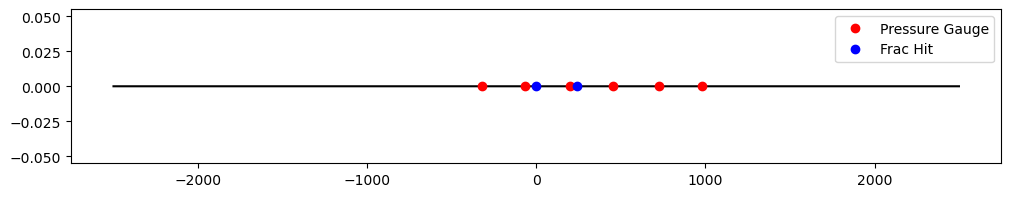

In [121]:
# Plot the location of the pressure gauge and frac hit
plt.figure(figsize=(12, 2))
plt.plot(x, np.zeros(nx), 'k')
plt.plot(x[gauge_md_idx], np.zeros(gauge_md_idx.size), 'ro', label='Pressure Gauge')
plt.plot(x[frac_hit_idx], np.zeros(frac_hit_idx.size), 'bo', label='Frac Hit')
plt.legend()
plt.show()

# Phase 1
In this script, I'll investigate the possibility packing the code into a module.

Develop the code on **haynesville** then call the module here.

In [122]:
from pds.core import pds

In [123]:
pds_frame_phase1 = pds.PDS1D_SingleSource()

In [124]:
# Initialize the simulator
pds_frame_phase1.set_mesh(x)
pds_frame_phase1.set_diffusivity(d)
pds_frame_phase1.set_bcs('Neumann', 'Neumann')
pds_frame_phase1.set_t0(0) # Phase 1 starts at 0
pds_frame_phase1.set_sourceidx(frac_hit_idx[0]) # The source is at the first frac hit

In [125]:
# Process the pressure gauge data to get the source term
phase_1_pg_dataframe = gauge_dataframe.copy()
phase_1_pg_dataframe.crop(stage7_start_time, stage7_end_time)

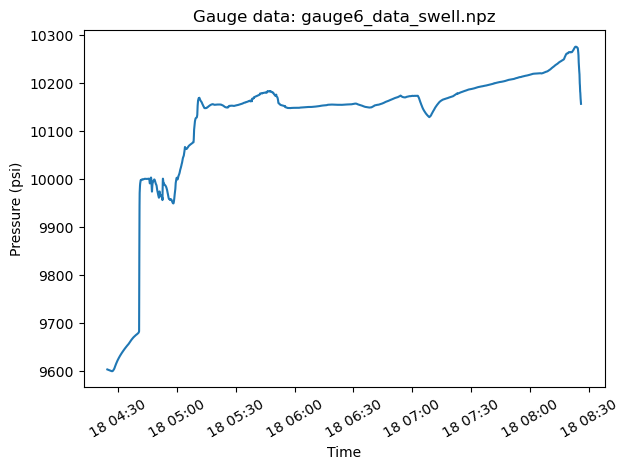

In [126]:
# QC the pressure gauge data
phase_1_pg_dataframe.plot_simple()

In [127]:
pds_frame_phase1.set_source(phase_1_pg_dataframe)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.


In [128]:
# Set the initial condition
u_initial = np.zeros(nx)
u_initial += phase_1_pg_dataframe.data[0]
pds_frame_phase1.set_initial(u_initial)

In [ ]:
pds_frame_phase1.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using the source term.


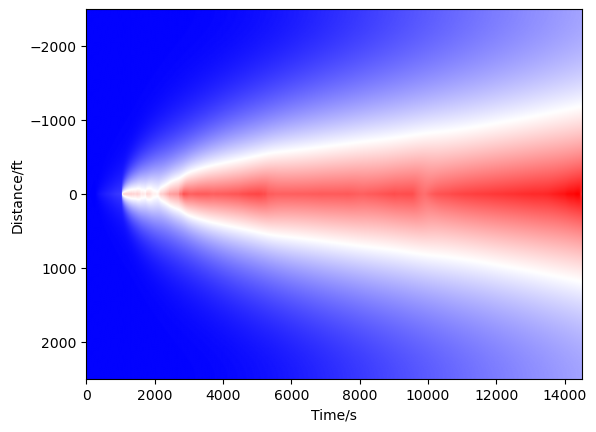

In [22]:
# show the solution
pds_frame_phase1.plot_solution()

# Phase 2

After the first phase:
- Keep the pressure gauge data
- Keep the diffusivity

In [23]:
# Calculate the total_time
total_time = stage8_start_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [24]:
# Initialize the simulator: Phase 2
pds_frame_phase2 = pds.PDS1D_SingleSource()
pds_frame_phase2.set_mesh(x)
pds_frame_phase2.set_diffusivity(d)
pds_frame_phase2.set_bcs('Neumann', 'Neumann')
pds_frame_phase2.set_t0(pds_frame_phase1.taxis[-1]) # Phase 2 starts after phase 1
pds_frame_phase2.set_sourceidx(frac_hit_idx[0]) # The source is at the first frac hit

In [25]:
# Process the pressure gauge data to get the source term
phase_2_pg_dataframe = gauge_dataframe.copy()
phase_2_pg_dataframe.crop(stage7_end_time, stage8_start_time)

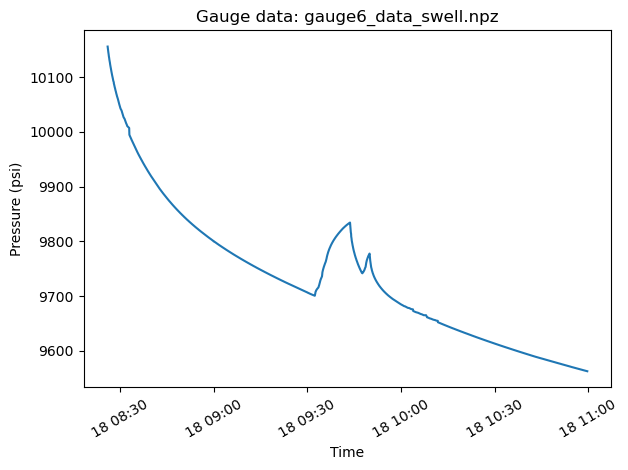

In [26]:
# QC the pressure gauge data
phase_2_pg_dataframe.plot_simple()

In [27]:
# Set the source term
pds_frame_phase2.set_source(phase_2_pg_dataframe)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.


In [28]:
# Set the initial condition
u_initial = pds_frame_phase1.snapshot[-1]
pds_frame_phase2.set_initial(u_initial)

In [29]:
pds_frame_phase2.solve(optimizer= True,
                       dt_init = 2,
                       t_total = total_time, # Phase 2 ends at the start of stage 8
                       print_progress=True,
                        max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2) # optional parameters

Time array generated using t_total.
Time: 14524 Source term: 10156.084
Time: 14527.354675046096 Source term: 10154.145334322453
Time: 14535.056448232812 Source term: 10151.246661278727
Time: 14552.378479468407 Source term: 10146.163369540107
Time: 14582.378479468407 Source term: 10134.283990203416
Time: 14612.378479468407 Source term: 10116.83086847015
Time: 14642.378479468407 Source term: 10101.81669923289
Time: 14672.378479468407 Source term: 10088.556356521443
Time: 14702.378479468407 Source term: 10076.465654042055
Time: 14732.378479468407 Source term: 10065.364876233609
Time: 14762.378479468407 Source term: 10055.13554025103
Time: 14792.378479468407 Source term: 10045.21382325798
Time: 14822.378479468407 Source term: 10038.240231385766
Time: 14852.378479468407 Source term: 10028.872581346432
Time: 14882.378479468407 Source term: 10022.726526216848
Time: 14912.378479468407 Source term: 10015.009491974315
Time: 14942.378479468407 Source term: 10009.556406978845
Time: 14972.378479468

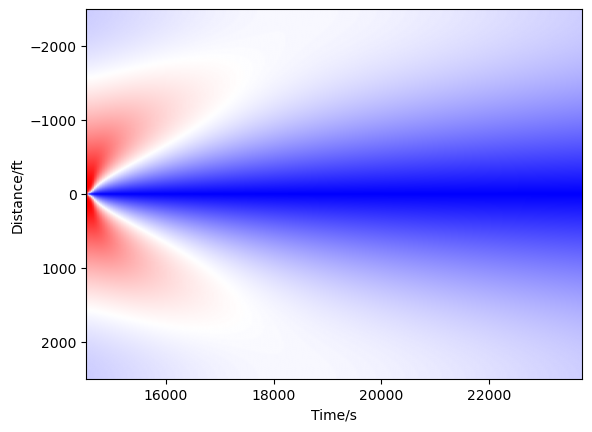

In [30]:
# show the solution
pds_frame_phase2.plot_solution()

# Phase 3 / test

After the second phase:
- Release the pressure gauge data
- Change the diffusivity at first frac hit
- Use next pressure gauge data

In [90]:
# Change diffusivity ratio
diffusivity_change_ratio = np.array([1, 0.5, 0.1, 0.01, 0.001])

In [91]:
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [92]:
# Initialize the simulator: Phase 3
pds_frame_phase3 = pds.PDS1D_SingleSource()
pds_frame_phase3.set_mesh(x)
pds_frame_phase3.set_bcs('Neumann', 'Neumann')
pds_frame_phase3.set_t0(pds_frame_phase2.taxis[-1]) # Phase 3 starts after phase 2
pds_frame_phase3.set_sourceidx(frac_hit_idx[1]) # The source is at the second frac hit

In [93]:
# Change the diffusivity at the first frac hit
d = 140 * np.ones(nx)
d[frac_hit_idx[0]] = diffusivity_change_ratio[-2] * d[frac_hit_idx[0]] * 0
pds_frame_phase3.set_diffusivity(d)

In [94]:
# Process the pressure gauge data to get the source term
phase_3_pg_dataframe = gauge_dataframe_next.copy()
phase_3_pg_dataframe.crop(stage8_start_time, stage8_end_time)

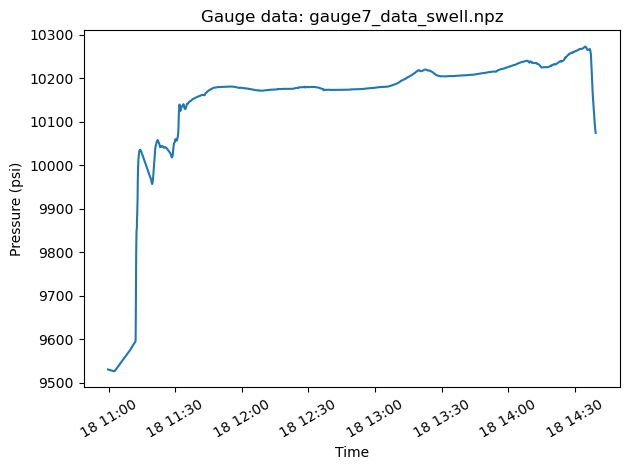

In [95]:
# QC the pressure gauge data
phase_3_pg_dataframe.plot_simple()

In [96]:
# Set the source term
pds_frame_phase3.set_source(phase_3_pg_dataframe)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.


In [97]:
# Set the initial condition
u_initial = pds_frame_phase2.snapshot[-1]
pds_frame_phase3.set_initial(u_initial)

In [ ]:
pds_frame_phase3.solve(optimizer= True,
                       dt_init = 2,
                       t_total = total_time, # Phase 3 ends at the end of stage 8
                       print_progress=True,
                        max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2) # optional parameters

Time array generated using t_total.
Time: 23734.378479468407 Source term: 9530.631
Time: 23738.11064712681 Source term: 9530.574
Time: 23747.333126169033 Source term: 9530.478005022658
Time: 23769.40724243187 Source term: 9530.230119116248
Time: 23799.40724243187 Source term: 9529.605198150934
Time: 23829.40724243187 Source term: 9528.788369670441
Time: 23859.40724243187 Source term: 9527.949273228707
Time: 23889.40724243187 Source term: 9527.126784886283


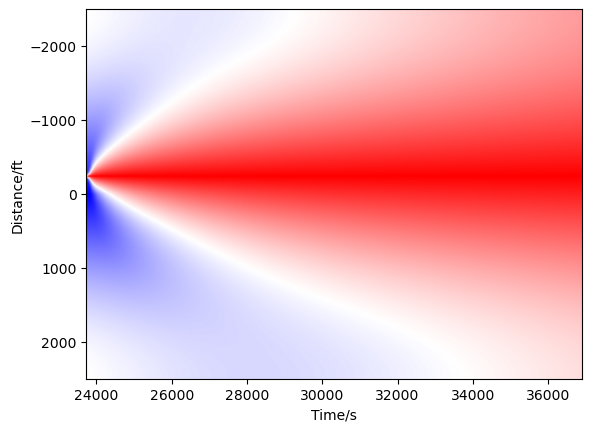

In [100]:
# show the solution
pds_frame_phase3.plot_solution()

In [41]:
pds_frame_phase3.pack_result(filename="Phase3_prev.npz", mode="dss_analyzer_mariner")

0

# Phase 3 / Full

Test the diffusivity change at the first frac hit. Use a list of diffusivity change ratio.

In [42]:
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [43]:
# Initialize the simulator: Phase 3
pds_frame_phase3_all = []

In [44]:
for iter in diffusivity_change_ratio:
    pds_frame_phase3_iter = pds.PDS1D_SingleSource()
    pds_frame_phase3_iter.set_mesh(x)
    pds_frame_phase3_iter.set_bcs('Neumann', 'Neumann')
    pds_frame_phase3_iter.set_t0(pds_frame_phase2.taxis[-1]) # Phase 3 starts after phase 2
    pds_frame_phase3_iter.set_sourceidx(frac_hit_idx[1]) # The source is at the second frac hit
    # Change the diffusivity at the first frac hit
    # First, set the diffusivity
    d = 140 * np.ones(nx)
    d[frac_hit_idx[0]] = iter * d[frac_hit_idx[0]]
    pds_frame_phase3_iter.set_diffusivity(d)
    # Use the next pressure gauge data which I have already loaded
    pds_frame_phase3_iter.set_source(phase_3_pg_dataframe)
    # Set the initial condition
    u_initial = pds_frame_phase2.snapshot[-1]
    pds_frame_phase3_iter.set_initial(u_initial)
    # Solve
    pds_frame_phase3_iter.solve(optimizer= True,
                       dt_init = 2,
                       t_total = total_time, # Phase 3 ends at the end of stage 8
                       print_progress=True,
                        max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2) # optional parameters
    pds_frame_phase3_all.append(pds_frame_phase3_iter)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.
Time array generated using t_total.
Time: 23734.378479468407 Source term: 9530.631
Time: 23738.11062789923 Source term: 9530.574
Time: 23747.332677048973 Source term: 9530.478005399795
Time: 23769.407670525663 Source term: 9530.230128735851
Time: 23799.407670525663 Source term: 9529.605184550373
Time: 23829.407670525663 Source term: 9528.788356187173
Time: 23859.407670525663 Source term: 9527.94926391609
Time: 23889.407670525663 Source term: 9527.126773023694
Time: 23919.407670525663 Source term: 9526.541019194963
Time: 23949.407670525663 Source term: 9527.793601399308
Time: 23979.407670525663 Source term: 9531.024933930426
Time: 24009.407670525663 Source term: 9534.551015020641
Time: 24039.407670525663 Source term: 9537.964138702759
Time: 24069.407670525663 Source term: 9541.561251241914
Time: 24099.407670525663 Source term: 9545.042602607276
Time: 24129.407670525663 Source term: 9

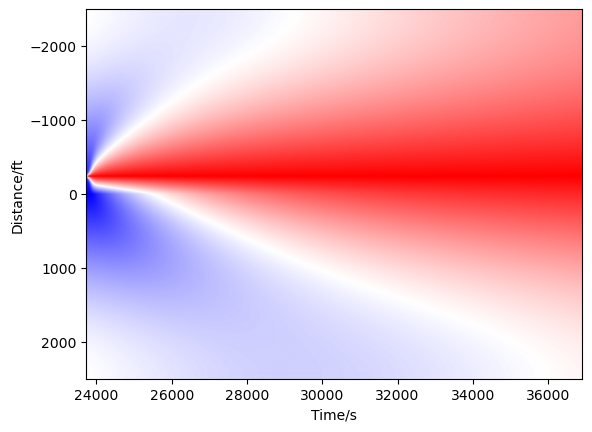

In [59]:
pds_frame_phase3_all[-1].plot_solution()

In [108]:
pds_frame_phase3_all[-1].pack_result(filename="phase3_new.npz")

0

# Post-processing

In [101]:
# Combine the results -> snapshot
snapshot_result_all = np.concatenate([pds_frame_phase1.snapshot, pds_frame_phase2.snapshot], axis=0)
snapshot_result_all = np.concatenate([snapshot_result_all, pds_frame_phase3_all[-1].snapshot], axis=0)

In [102]:
np.shape(snapshot_result_all)

(1240, 5000)

In [103]:
# Combine the results -> taxis
taxis_result_all = np.concatenate([pds_frame_phase1.taxis, pds_frame_phase2.taxis], axis=0)
taxis_result_all = np.concatenate([taxis_result_all, pds_frame_phase3_all[2].taxis], axis=0)

In [104]:
np.shape(taxis_result_all)

(1240,)

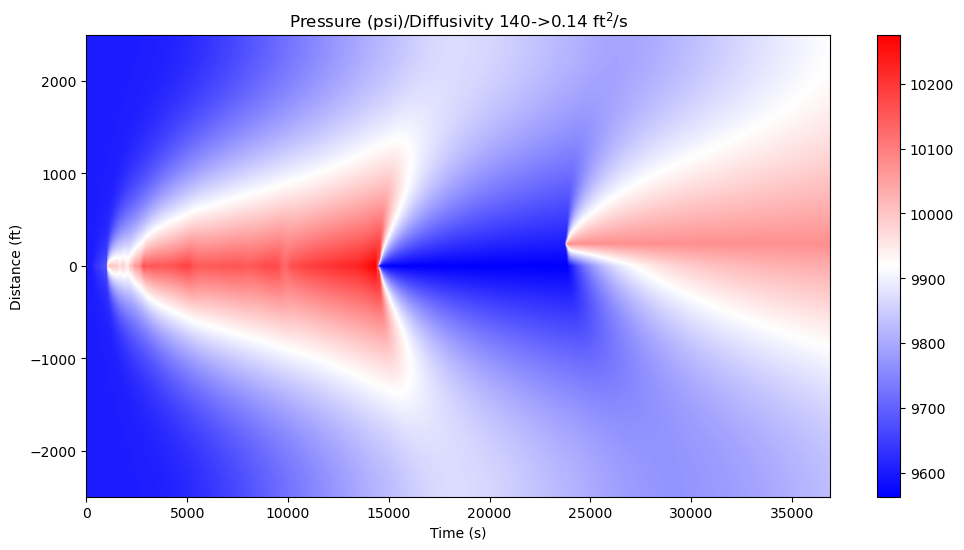

In [106]:
# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(snapshot_result_all.T, aspect='auto', cmap='bwr', extent=[taxis_result_all[0], taxis_result_all[-1], x[-1], x[0]])
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title('Pressure (psi)/Diffusivity 140->0.14 ft$^2$/s')
plt.gca().invert_yaxis()
plt.show()

In [87]:
# Get the value of the pressure at the pressure gauge location
pg_value = []
for pg in gauge_md_idx:
    pg_value.append(snapshot_result_all[:, pg])

In [89]:
gauge_md_idx

array([2176, 2431, 2700, 2954, 3223, 3478])

In [79]:
pg_value = np.array(pg_value)
np.shape(pg_value)

(6, 1240)

In [80]:
# Load the real pressure gauge data
real_pg_data = []
real_pg_data_taxis = []
gauge_num = [5, 6, 7, 8, 9, 10]
for num in gauge_num:
    gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_foler + f"/gauge{num}_data_swell.npz")
    gauge_dataframe.crop(stage7_start_time, stage8_end_time)
    time_sec = gauge_dataframe.calculate_time() * 3600
    real_pg_data.append(gauge_dataframe.data)
    real_pg_data_taxis.append(time_sec)

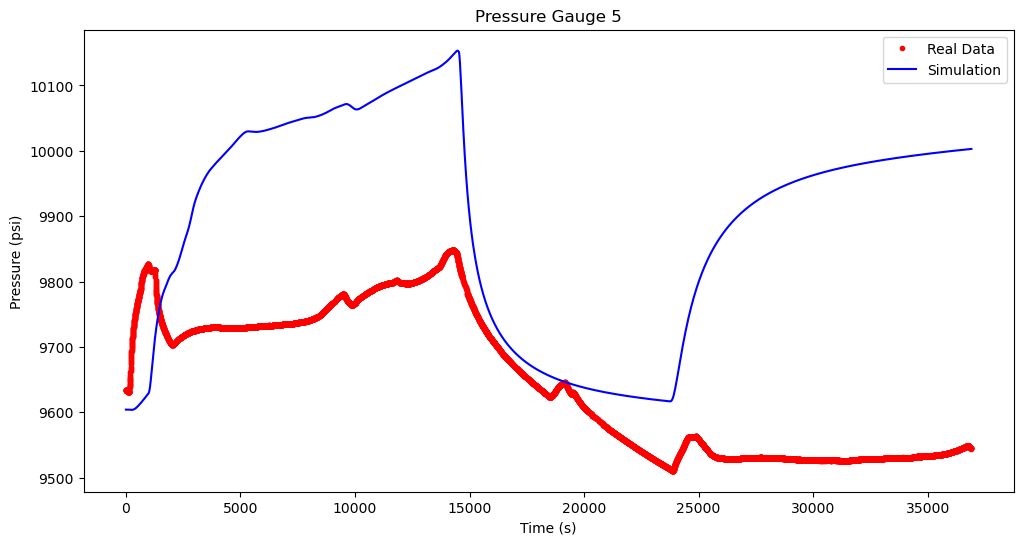

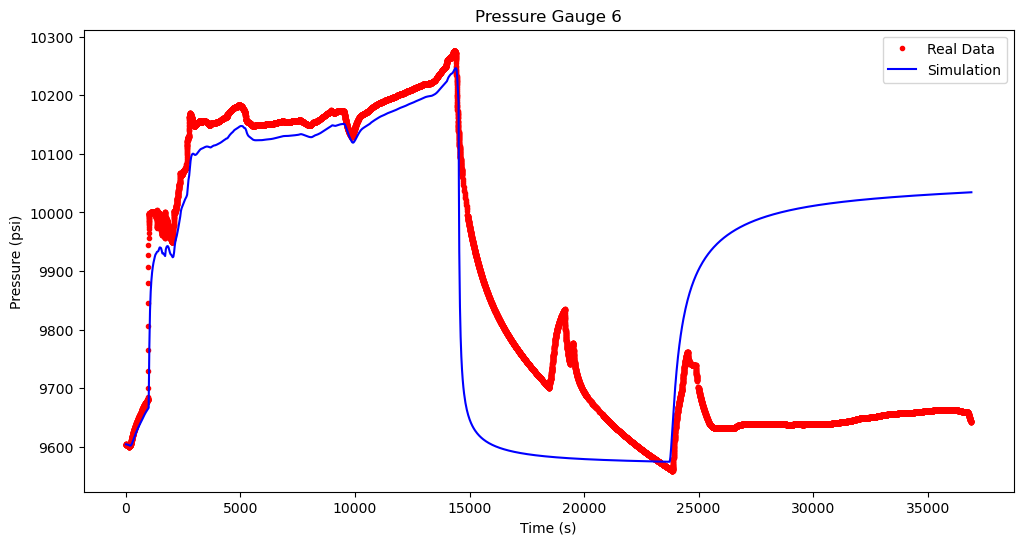

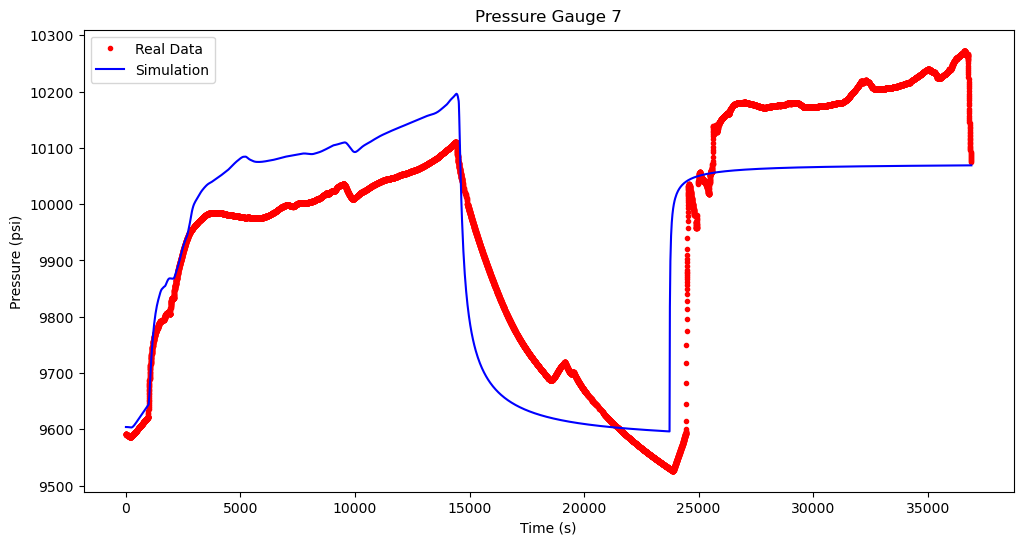

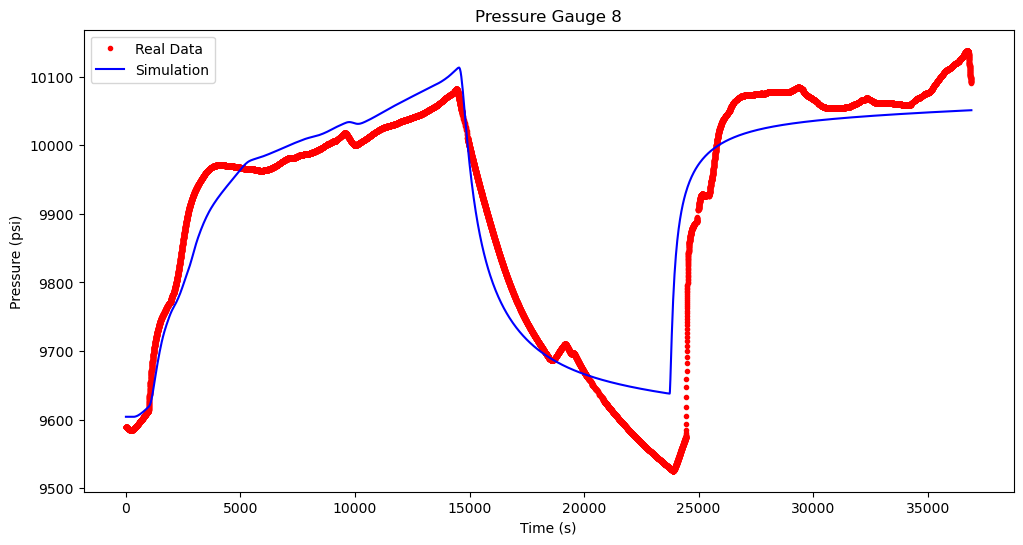

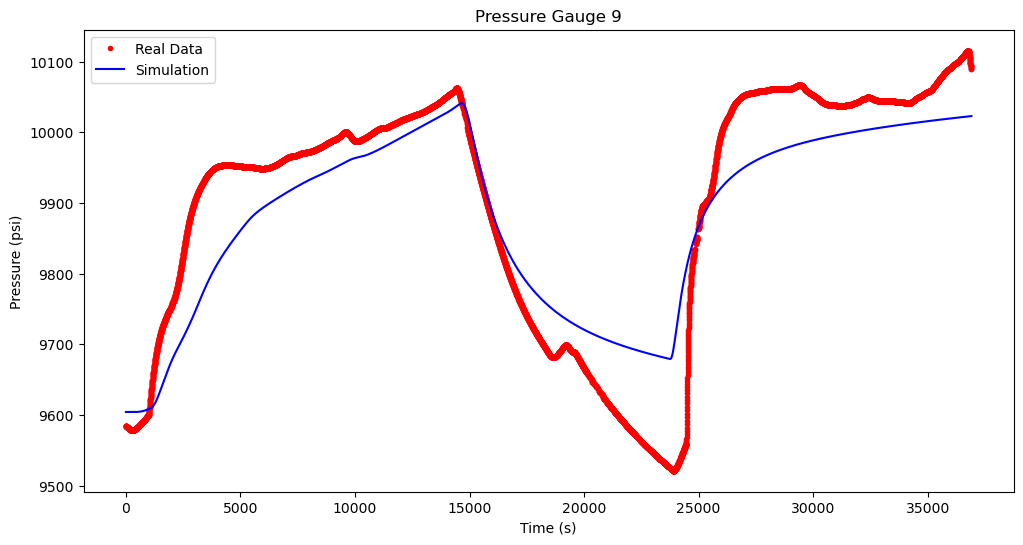

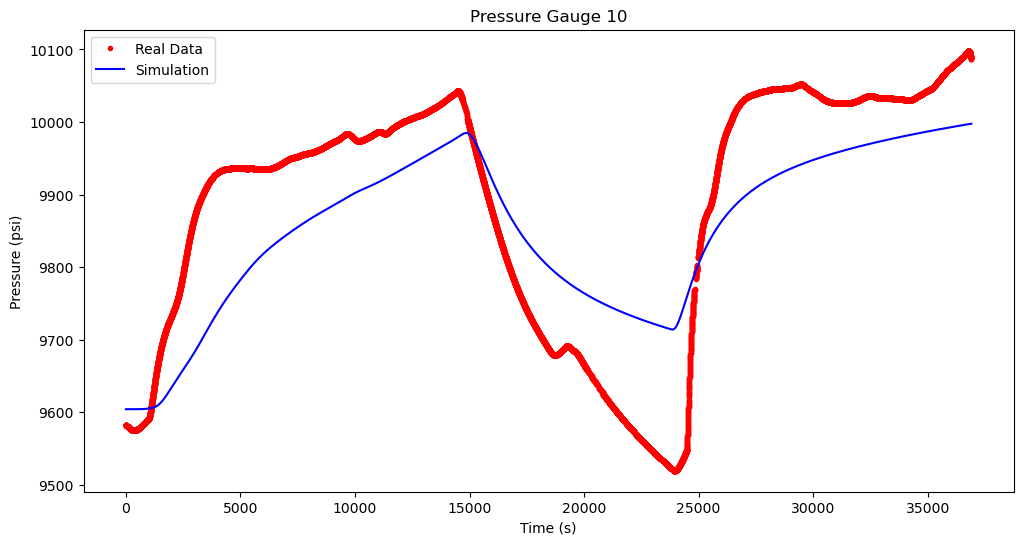

In [81]:
# Compare the simulation and real data
for i in range(len(gauge_num)):
    plt.figure(figsize=(12, 6))
    plt.plot(real_pg_data_taxis[i], real_pg_data[i], 'ro', label='Real Data', markersize=3)
    plt.plot(taxis_result_all, pg_value[i], 'b-', label='Simulation')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (psi)')
    plt.title(f'Pressure Gauge {gauge_num[i]}')
    plt.show()

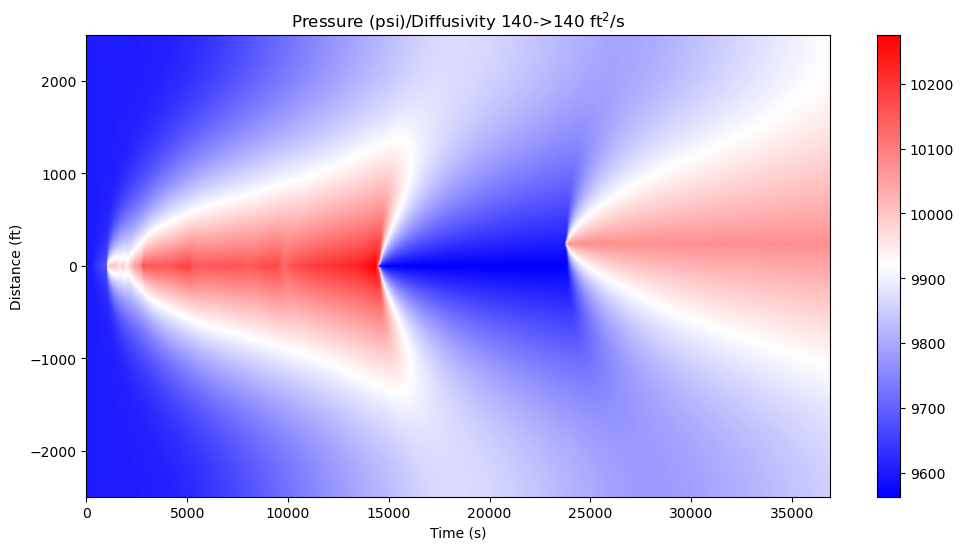

In [70]:
# Combine the results -> snapshot
snapshot_result_all = np.concatenate([pds_frame_phase1.snapshot, pds_frame_phase2.snapshot], axis=0)
snapshot_result_all = np.concatenate([snapshot_result_all, pds_frame_phase3_all[0].snapshot], axis=0)
np.shape(snapshot_result_all)
# Combine the results -> taxis
taxis_result_all = np.concatenate([pds_frame_phase1.taxis, pds_frame_phase2.taxis], axis=0)
taxis_result_all = np.concatenate([taxis_result_all, pds_frame_phase3_all[0].taxis], axis=0)
np.shape(taxis_result_all)
# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(snapshot_result_all.T, aspect='auto', cmap='bwr',
           extent=[taxis_result_all[0], taxis_result_all[-1], x[-1], x[0]])
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title('Pressure (psi)/Diffusivity 140->140 ft$^2$/s')
plt.gca().invert_yaxis()
plt.show()

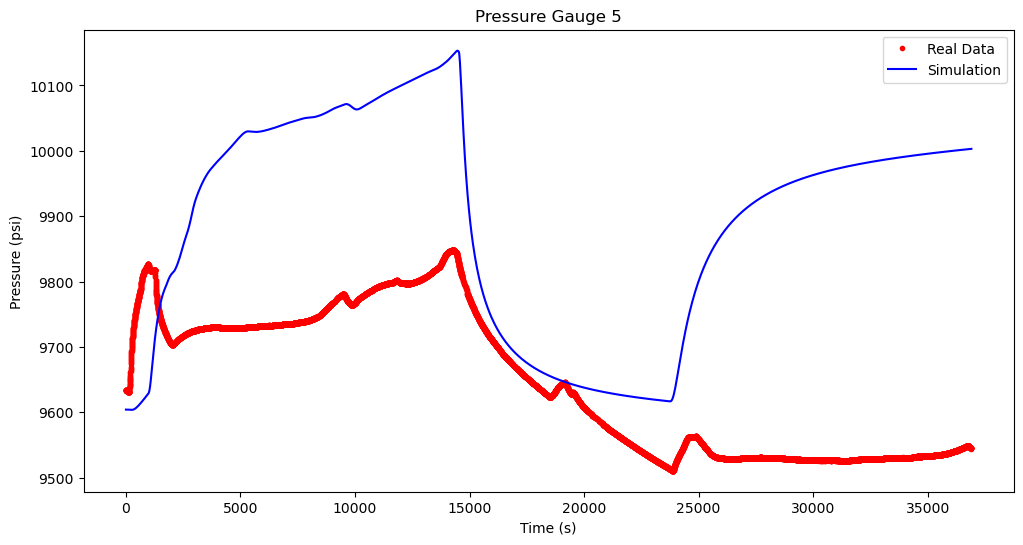

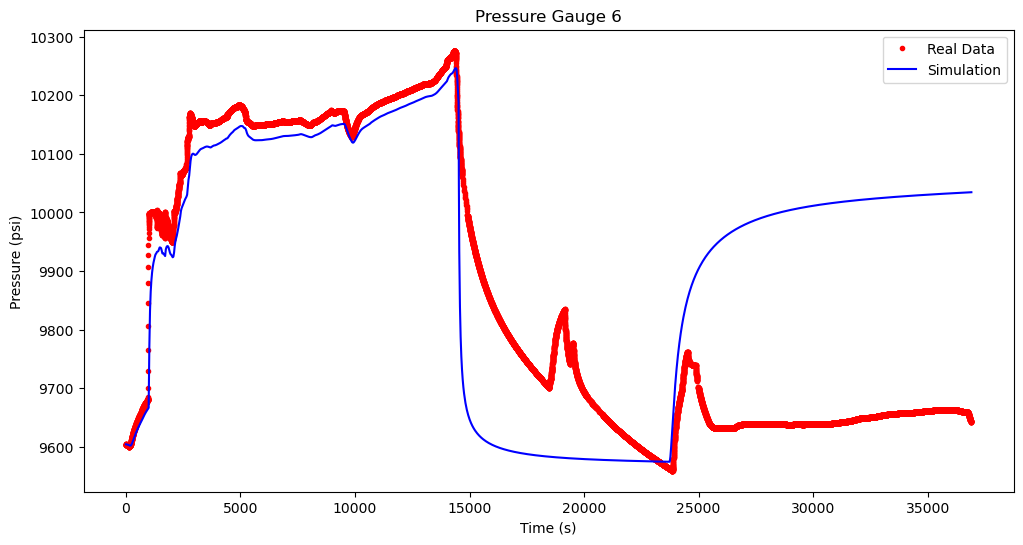

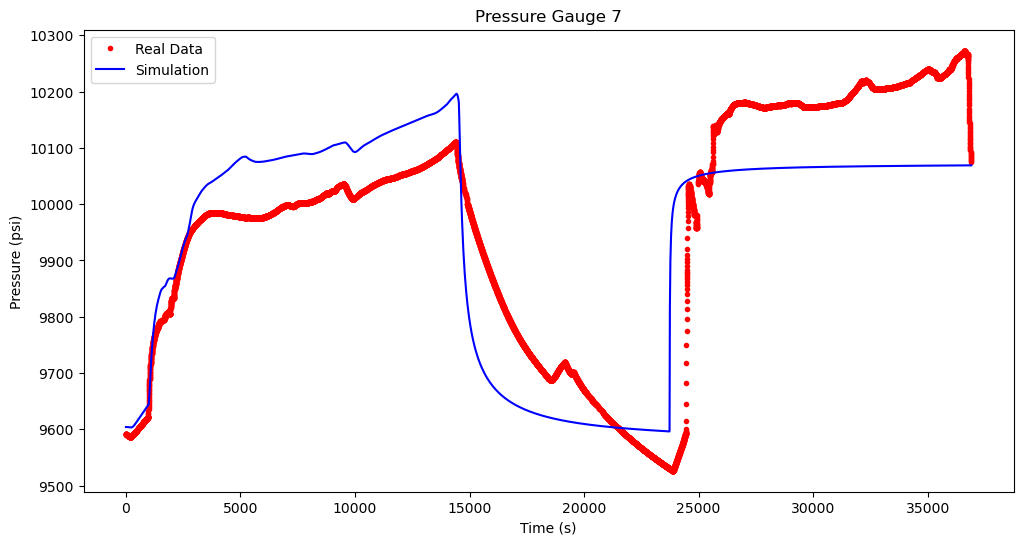

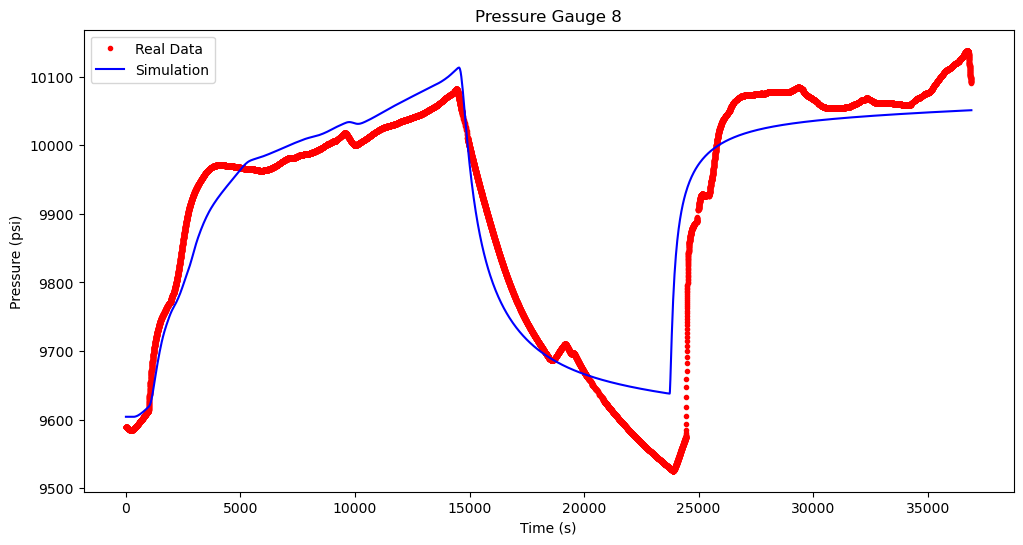

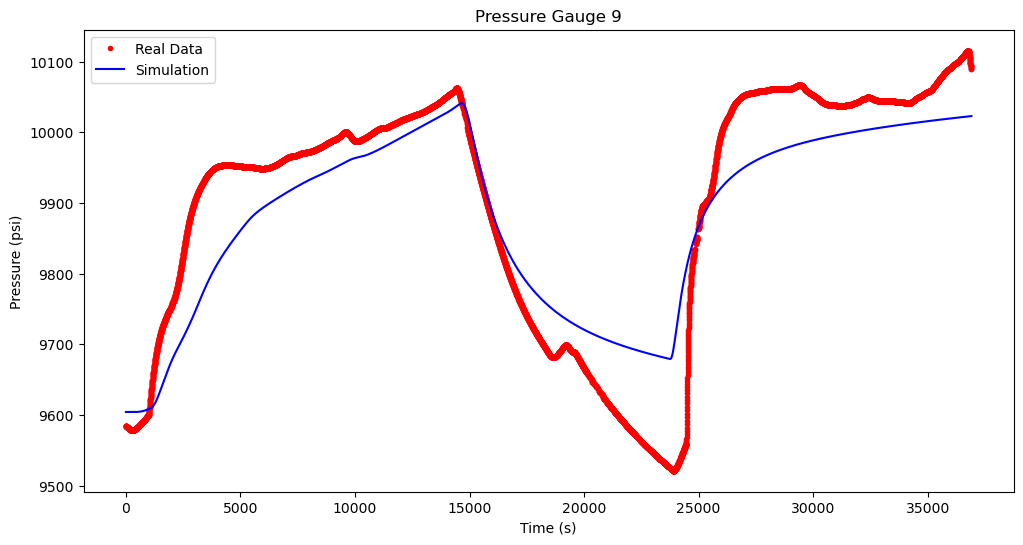

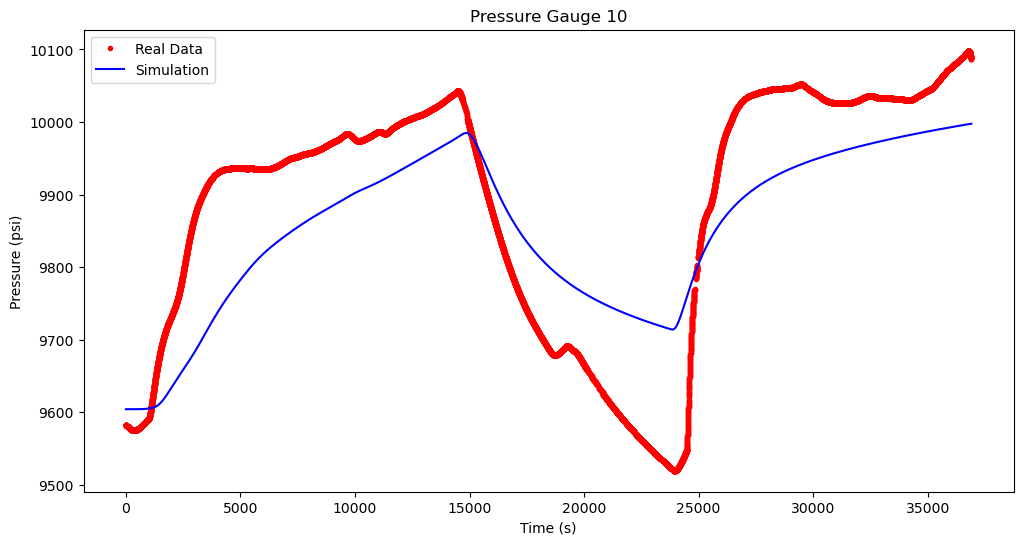

In [71]:
# Get the value of the pressure at the pressure gauge location
pg_value = []
for pg in gauge_md_idx:
    pg_value.append(snapshot_result_all[:, pg])
pg_value = np.array(pg_value)
np.shape(pg_value)

# Compare the simulation and real data
for i in range(len(gauge_num)):
    plt.figure(figsize=(12, 6))
    plt.plot(real_pg_data_taxis[i], real_pg_data[i], 'ro', label='Real Data', markersize=3)
    plt.plot(taxis_result_all, pg_value[i], 'b-', label='Simulation')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (psi)')
    plt.title(f'Pressure Gauge {gauge_num[i]}')
    plt.show()